# Consumer Segmentation
Input: transaction data, aggregated app data <br>

Output: 
1. Aggregated results to user level 
2. Principal Component Analysis
3. K-means Clustering - scoring results

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns #visualisation
import matplotlib.pyplot as plt #visualisation
%matplotlib inline 
sns.set(color_codes=True)

In [2]:
# Load transaction data
df3 = pd.read_csv('CleanedTransaction.csv')
df3.create_dt = pd.to_datetime(df3['create_dt'])
df3.acct_create_dt = pd.to_datetime(df3['acct_create_dt'])

df3.info()

print(df3.acct_id.nunique())
df3.head()

C:\Users\steve\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3331747 entries, 0 to 3331746
Data columns (total 17 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Unnamed: 0             int64         
 1   acct_id                object        
 2   acct_create_dt         datetime64[ns]
 3   payment_type           object        
 4   create_dt              datetime64[ns]
 5   content_id             object        
 6   price                  float64       
 7   device_id              int64         
 8   parent_app_content_id  object        
 9   type                   object        
 10  app_name               object        
 11  category_id            object        
 12  app_device_id          int64         
 13  category_name          object        
 14  app_device_name        object        
 15  _merge                 object        
 16  in-app                 int64         
dtypes: datetime64[ns](2), float64(1), int64(4), object(10)
memory usa

,Unnamed: 0,acct_id,acct_create_dt,payment_type,create_dt,content_id,price,device_id,parent_app_content_id,type,app_name,category_id,app_device_id,category_name,app_device_name,_merge,in-app
0,0,9b6d6fbf76504d85,2008-11-06,PMOF,2016-08-29,a013e9d8a77241b8,11.99,1,a97a0c4386d37a1f,consumable,ceases half;,Z-1,3,Games,Both,both,1
1,1,9b6d6fbf76504d85,2008-11-06,PMOF,2016-06-17,a013e9d8a77241b8,11.99,1,a97a0c4386d37a1f,consumable,ceases half;,Z-1,3,Games,Both,both,1
2,2,65cefe068226ffab,2012-11-01,PMOF,2016-08-04,a013e9d8a77241b8,11.99,1,a97a0c4386d37a1f,consumable,ceases half;,Z-1,3,Games,Both,both,1
3,3,527fa71ddd4beba6,2008-09-18,PMOF,2016-07-04,a013e9d8a77241b8,11.99,1,a97a0c4386d37a1f,consumable,ceases half;,Z-1,3,Games,Both,both,1
4,4,f0455d7331b1c842,2012-04-08,PMOF,2016-06-28,a013e9d8a77241b8,11.99,1,a97a0c4386d37a1f,consumable,ceases half;,Z-1,3,Games,Both,both,1


In [3]:
# Join with app data & ratio of one-time purchase
appnew = pd.read_csv('appnew.csv')
df3 = pd.merge(df3, appnew, on = 'parent_app_content_id', how ='outer')


In [4]:
df3 = df3.drop(['_merge','Unnamed: 0_y'], axis = 1)
print(df3.shape)

(3331747, 18)


#### Transaction data aggregated to user level

In [5]:
dfI = df3.groupby(['acct_id','acct_create_dt']).agg({'acct_id':'count',
                                                    'price':['sum','mean'],
                                                     'create_dt':['max','min'],
                                                    'in-app':'sum',
                                                    'payment_type':'nunique',
                                                    'category_name':'nunique',
                                                    'content_id':'nunique'}).reset_index()
dfI.columns = ['acct_id','acct_create_dt','trans_ct','total_price',
              'avg_price','max_trans_dt','min_trans_dt','in_app_trans_ct',
              'payment_ct','app_category_ct','content_ct']

dfI.head(3)

,acct_id,acct_create_dt,trans_ct,total_price,avg_price,max_trans_dt,min_trans_dt,in_app_trans_ct,payment_ct,app_category_ct,content_ct
0,00028709c8d435ff,2013-11-25,71,0.00,0.000000,2016-09-21,2016-06-02,0,1,5,61
1,0005a4d77127fde7,2007-12-20,140,1048.69,7.490643,2016-09-21,2016-06-01,114,1,5,134
2,0005c296f2605c08,2011-04-02,153,1208.55,7.899020,2016-09-21,2016-06-01,126,1,5,146


#### Transaction data w/ criteria aggregated to user level

In [6]:
dfI2 = df3.groupby('acct_id').apply(lambda x: pd.Series(dict(
        game_trans = (x.category_name == 'Games').sum(),
        social_trans = (x.category_name == 'Social Networking').sum(),
        utili_trans = (x.category_name == 'Utilities').sum(),
        entertain_trans = (x.category_name == 'Entertainment').sum(),
        photo_trans = (x.category_name == 'Photos & Videos').sum(),
        inapp_consum_trans = (x.type == 'consumable').sum(),
        inapp_subsc_trans = (x.type == 'subscription').sum(),
        iphone_trans = (x.device_id == 1).sum(),
        ipad_trans = (x.device_id == 2).sum()
))).reset_index()

dfI2.head(3)

,acct_id,game_trans,social_trans,utili_trans,entertain_trans,photo_trans,inapp_consum_trans,inapp_subsc_trans,iphone_trans,ipad_trans
0,00028709c8d435ff,27,1,14,10,19,0,0,48,23
1,0005a4d77127fde7,78,7,11,17,27,101,13,99,41
2,0005c296f2605c08,79,3,13,13,45,115,11,108,45


#### Additional variables created with filtered data and joined to dfI2

In [7]:
def mergeto(data, data2, name1, name2):
    data2 = data2.reset_index().rename(columns = {str(name1):str(name2)})
    data = pd.merge(data, data2, on = 'acct_id', how = 'left')
    print(data.shape)
    return data

In [8]:
# Total transaction value on gaming apps
a = df3.loc[df3.category_name == 'Games',['acct_id','price']]
a = a.groupby('acct_id').agg({'price':'sum'})

# Total count of transactions with non-free apps
b = df3.loc[df3.price > 0,['acct_id','price']]
b = b.groupby('acct_id').count()

# Total count of transactions with apps more than $10
c = df3.loc[df3.price > 10,['acct_id','price']]
c = c.groupby('acct_id').count()

# Total purchase in one single app
d= df3.loc[df3.price > 0,['acct_id', 'app_name','content_id']]
d = d.groupby(['acct_id','app_name'])['content_id'].count().reset_index()
d = d.groupby('acct_id')['content_id'].max()

dfI2 = mergeto(dfI2, a, 'price','game_trans_amount')
dfI2 = mergeto(dfI2, b,'price','non_free_trans' )
dfI2 = mergeto(dfI2, c,'price','10plus_trans')
dfI2 = mergeto(dfI2, d, 'content_id','max_purchase_single_app')

(26488, 11)
(26488, 12)
(26488, 13)
(26488, 14)


In [9]:
def topapp(data, alist):
    data2 = data.loc[data.app_name.isin(alist)]
    data2 = data2.groupby('acct_id')['content_id'].count()
    return data2

In [10]:
# Total purchase of top apps

e = ['unwritten hungry','remote remaining','aright Davy',
                             'ceases half;','fowls;--though grieved'] # top 5 game apps
f = ['make covered','strand preliminaries','WARRANTY nails;'] # top 3 photo apps
g = ['aunts hat','reverberating pipes',"Sleet's perceived"] # top 3 social apps
h = ['Over grandmother','pegging them;',"evening--it surprise"] # top 3 entertainment apps
i = ['mornings belongs','chamber chief-mateship',"hen's half-crazy"] # top 3 utilities apps

dfI2 = mergeto(dfI2,topapp(df3, e), 'content_id','top5_game_trans')
dfI2 = mergeto(dfI2,topapp(df3, f), 'content_id','top3_photo_trans')
dfI2 = mergeto(dfI2,topapp(df3, g), 'content_id','top3_social_trans')
dfI2 = mergeto(dfI2,topapp(df3, h), 'content_id','top3_entertain_trans')
dfI2 = mergeto(dfI2,topapp(df3, i), 'content_id','top3_utili_trans')

(26488, 15)
(26488, 16)
(26488, 17)
(26488, 18)
(26488, 19)


In [11]:
# Total Purchase of high ratio of one-time purchase apps

l = df3.loc[df3.high_one_time == 1,['acct_id', 'app_name','content_id']]
l = l.groupby('acct_id')['content_id'].count()

# Total Purchase of mid ratio of one-time purchase apps
m = df3.loc[df3.high_one_time == 2,['acct_id', 'app_name','content_id']]
m = m.groupby('acct_id')['content_id'].count()

# Total Purchase of low ratio of one-time purchase apps
n = df3.loc[df3.high_one_time == 3,['acct_id', 'app_name','content_id']]
n = n.groupby('acct_id')['content_id'].count()


dfI2 = mergeto(dfI2, l, 'content_id', 'high_one_1_trans')
dfI2 = mergeto(dfI2, m, 'content_id', 'high_one_2_trans')
dfI2 = mergeto(dfI2, n, 'content_id', 'high_one_3_trans')

(26488, 20)
(26488, 21)
(26488, 22)


In [12]:
# Join dfI and dfI2
dfI = pd.merge(dfI, dfI2, on = 'acct_id', how = 'left')
print(dfI.shape)
dfI.head(3)

(26488, 32)


,acct_id,acct_create_dt,trans_ct,total_price,avg_price,max_trans_dt,min_trans_dt,in_app_trans_ct,payment_ct,app_category_ct,...,10plus_trans,max_purchase_single_app,top5_game_trans,top3_photo_trans,top3_social_trans,top3_entertain_trans,top3_utili_trans,high_one_1_trans,high_one_2_trans,high_one_3_trans
0,00028709c8d435ff,2013-11-25,71,0.00,0.000000,2016-09-21,2016-06-02,0,1,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32,39
1,0005a4d77127fde7,2007-12-20,140,1048.69,7.490643,2016-09-21,2016-06-01,114,1,5,...,37.0,4.0,15.0,4.0,2.0,2.0,1.0,18.0,35,87
2,0005c296f2605c08,2011-04-02,153,1208.55,7.899020,2016-09-21,2016-06-01,126,1,5,...,49.0,4.0,10.0,2.0,2.0,4.0,1.0,23.0,46,84


#### Create calculated features

In [13]:
# Tenure
dfI['tenure'] = (dfI.min_trans_dt - dfI.acct_create_dt).dt.days.astype(int)
dfI['duration'] = (dfI.max_trans_dt - dfI.min_trans_dt).dt.days.astype(int)
dfI['transgap'] = (dfI['duration']/dfI['trans_ct']).astype(float)

# Transactions
dfI['ratio_non_free'] = dfI['non_free_trans']/ dfI['trans_ct']
dfI['ratio_10plus'] = dfI['10plus_trans']/ dfI['trans_ct']

dfI['ratio_games'] = dfI['game_trans']/ dfI['trans_ct']
dfI['ratio_social'] = dfI['social_trans']/ dfI['trans_ct']
dfI['ratio_utili'] = dfI['utili_trans']/ dfI['trans_ct']
dfI['ratio_entertain'] = dfI['entertain_trans']/ dfI['trans_ct']
dfI['ratio_photo'] = dfI['photo_trans']/ dfI['trans_ct']
dfI['ratio_inapp_subscrb'] = dfI['inapp_subsc_trans']/ dfI['in_app_trans_ct']
dfI['ratio_inapp'] = dfI['in_app_trans_ct']/ dfI['trans_ct']
dfI['ratio_iphone'] = dfI['iphone_trans']/ dfI['trans_ct']
dfI['ratio_max_single_app'] = dfI['max_purchase_single_app']/ dfI['trans_ct']

#Top purchases
dfI['ratio_top5games'] = dfI['top5_game_trans'] / dfI['game_trans']
dfI['ratio_top3social'] = dfI['top3_social_trans'] / dfI['social_trans']
dfI['ratio_top3utili'] = dfI['top3_utili_trans'] /  dfI['utili_trans']
dfI['ratio_top3entertain'] = dfI['top3_entertain_trans'] / dfI['entertain_trans']
dfI['ratio_top3photo'] = dfI['top3_photo_trans'] / dfI['photo_trans']

#High One
dfI['ratio_highone95'] = dfI['high_one_1_trans'] / dfI['trans_ct']
dfI['ratio_highone84'] = dfI['high_one_2_trans'] / dfI['trans_ct']
dfI['ratio_highone60'] = dfI['high_one_3_trans'] / dfI['trans_ct']
dfI.head()

,acct_id,acct_create_dt,trans_ct,total_price,avg_price,max_trans_dt,min_trans_dt,in_app_trans_ct,payment_ct,app_category_ct,...,ratio_iphone,ratio_max_single_app,ratio_top5games,ratio_top3social,ratio_top3utili,ratio_top3entertain,ratio_top3photo,ratio_highone95,ratio_highone84,ratio_highone60
0,00028709c8d435ff,2013-11-25,71,0.00,0.000000,2016-09-21,2016-06-02,0,1,5,...,0.676056,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.450704,0.549296
1,0005a4d77127fde7,2007-12-20,140,1048.69,7.490643,2016-09-21,2016-06-01,114,1,5,...,0.707143,0.028571,0.192308,0.285714,0.090909,0.117647,0.148148,0.128571,0.250000,0.621429
2,0005c296f2605c08,2011-04-02,153,1208.55,7.899020,2016-09-21,2016-06-01,126,1,5,...,0.705882,0.026144,0.126582,0.666667,0.076923,0.307692,0.044444,0.150327,0.300654,0.549020
3,00082ad3dc50a70d,2015-05-16,76,0.00,0.000000,2016-09-18,2016-06-02,0,1,5,...,0.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.315789,0.684211
4,00085ff73786df4d,2012-03-04,158,1255.51,7.946266,2016-09-21,2016-06-01,135,1,5,...,0.715190,0.037975,0.221053,0.500000,NaN,0.125000,0.189189,0.113924,0.221519,0.664557


In [14]:
# Drop the original fields
dfF = dfI.drop(['acct_create_dt','max_trans_dt','min_trans_dt','payment_ct','app_category_ct','inapp_subsc_trans',
                'payment_ct','max_purchase_single_app','high_one_3_trans','high_one_2_trans',
               'top5_game_trans','top3_social_trans','top3_utili_trans',
               'top3_entertain_trans','top3_photo_trans','social_trans',
               'high_one_1_trans','content_ct','game_trans','utili_trans','entertain_trans','photo_trans',
                  'inapp_consum_trans','ipad_trans','non_free_trans','10plus_trans','iphone_trans'], axis = 1)

In [15]:
# Fill NAN values with zero (because these are all calculated fields)
dfF = dfF.fillna(0)

In [16]:
dfF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26488 entries, 0 to 26487
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   acct_id               26488 non-null  object 
 1   trans_ct              26488 non-null  int64  
 2   total_price           26488 non-null  float64
 3   avg_price             26488 non-null  float64
 4   in_app_trans_ct       26488 non-null  int64  
 5   game_trans_amount     26488 non-null  float64
 6   tenure                26488 non-null  int32  
 7   duration              26488 non-null  int32  
 8   transgap              26488 non-null  float64
 9   ratio_non_free        26488 non-null  float64
 10  ratio_10plus          26488 non-null  float64
 11  ratio_games           26488 non-null  float64
 12  ratio_social          26488 non-null  float64
 13  ratio_utili           26488 non-null  float64
 14  ratio_entertain       26488 non-null  float64
 15  ratio_photo        

In [17]:
#Required libraries for PCA and K-means

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from tqdm import tqdm

### PCA

A technique for reducing the dimensionality of one dataset. The goal is to reduce the number of dimensions needed to represent each data point by the principal components.


In [18]:
# Remove account_id
df_pca = dfF.iloc[:,1:]

print(df_pca.shape)
df_pca.head()

(26488, 27)


,trans_ct,total_price,avg_price,in_app_trans_ct,game_trans_amount,tenure,duration,transgap,ratio_non_free,ratio_10plus,...,ratio_iphone,ratio_max_single_app,ratio_top5games,ratio_top3social,ratio_top3utili,ratio_top3entertain,ratio_top3photo,ratio_highone95,ratio_highone84,ratio_highone60
0,71,0.00,0.000000,0,0.00,920,111,1.563380,0.000000,0.000000,...,0.676056,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.450704,0.549296
1,140,1048.69,7.490643,114,715.31,3086,112,0.800000,0.935714,0.264286,...,0.707143,0.028571,0.192308,0.285714,0.090909,0.117647,0.148148,0.128571,0.250000,0.621429
2,153,1208.55,7.899020,126,807.29,1887,112,0.732026,0.947712,0.320261,...,0.705882,0.026144,0.126582,0.666667,0.076923,0.307692,0.044444,0.150327,0.300654,0.549020
3,76,0.00,0.000000,0,0.00,383,108,1.421053,0.000000,0.000000,...,0.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.315789,0.684211
4,158,1255.51,7.946266,135,852.14,1550,112,0.708861,0.943038,0.303797,...,0.715190,0.037975,0.221053,0.500000,0.000000,0.125000,0.189189,0.113924,0.221519,0.664557


In [19]:
#Standardize the entire dataset
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_pca))
df_scaled.columns = df_pca.columns
df_scaled.index = df_pca.index
df_scaled.head()

,trans_ct,total_price,avg_price,in_app_trans_ct,game_trans_amount,tenure,duration,transgap,ratio_non_free,ratio_10plus,...,ratio_iphone,ratio_max_single_app,ratio_top5games,ratio_top3social,ratio_top3utili,ratio_top3entertain,ratio_top3photo,ratio_highone95,ratio_highone84,ratio_highone60
0,-0.561540,-0.737025,-1.134030,-0.689248,-0.786485,-0.740161,0.151018,1.425398,-1.140866,-1.120284,...,-1.145414,-1.056938,-1.070180,-0.826082,-0.804239,-0.745805,-0.873348,-1.091633,2.666121,-0.913172
1,0.145725,0.338853,0.800184,0.345706,0.429606,1.586728,0.766051,-0.646893,0.864547,0.706954,...,-0.419999,0.631118,1.119229,0.481820,0.103739,0.562897,1.746497,0.512517,-0.993554,0.208547
2,0.278977,0.502857,0.905634,0.454648,0.585980,0.298667,0.766051,-0.831416,0.890262,1.093963,...,-0.449413,0.487689,0.370950,2.225691,-0.035950,2.676954,-0.087394,0.783953,-0.069928,-0.917466
3,-0.510289,-0.737025,-1.134030,-0.689248,-0.786485,-1.317049,-1.694079,1.039032,-1.140866,-1.120284,...,0.580088,-1.056938,-1.070180,-0.826082,-0.804239,-0.745805,-0.873348,-1.091633,0.206062,1.184853
4,0.330228,0.551035,0.917834,0.536355,0.662229,-0.063365,0.766051,-0.894301,0.880243,0.980133,...,-0.232219,1.186681,1.446488,1.462747,-0.804239,0.644691,2.472265,0.329766,-1.512882,0.879225


In [20]:
# Apply PCA function to scaled result
pca = PCA().fit(df_scaled)

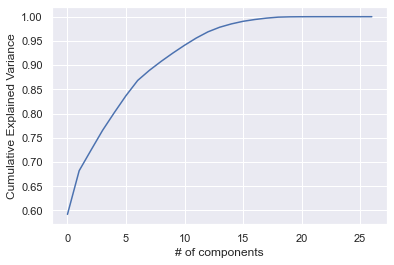

In [21]:
# Understand components vs explained variance
plt.plot(np.cumsum(pca.explained_variance_ratio_))

plt.xlabel('# of components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [22]:
#5 components explain 80% of the variance
reduced_pca = PCA(n_components=5)
df_pca = reduced_pca.fit_transform(df_scaled)

In [23]:
def pca_weight(pca, i):
    df = pd.DataFrame(pca.components_, columns=list(df_scaled.columns))
    weight = df.iloc[i].sort_values(ascending=False)
    
    fig, ax = plt.subplots(figsize=(10,20))
    ax = sns.barplot(weight, weight.index)
    return ax

C:\Users\steve\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='0'>

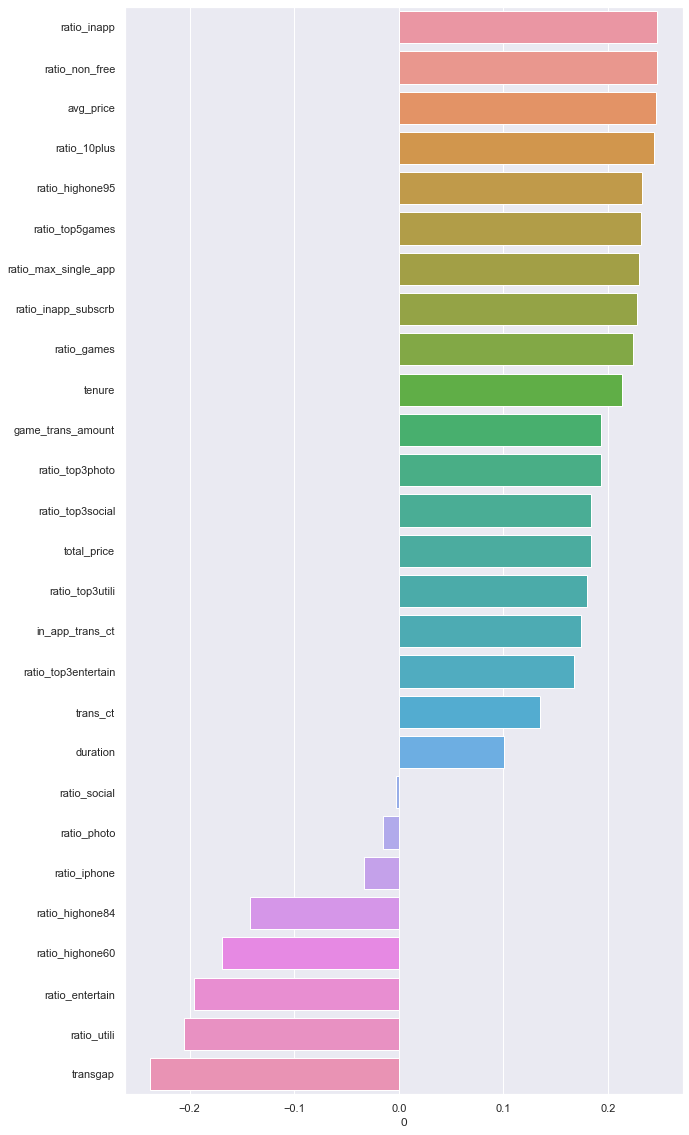

In [24]:
first_principal_weight = pca_weight(reduced_pca, 0)
first_principal_weight

### K-means Clustering

An algorithm to identify k number of centroids, and then allocate every data point to the nearest cluster, while keeping the difference within each cluster small and the difference between each cluster large.

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.71it/s]


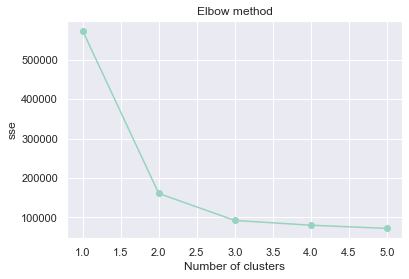

In [25]:
sse = []

sns.set_palette(sns.color_palette("GnBu_d", 7))

for i in tqdm(list(range(1,6))):
    km = KMeans(n_clusters = i)
    model = km.fit(df_pca)
    sse.append(np.abs(model.score(df_pca)))

plt.plot(range(1, 6), sse, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('sse')
plt.show()

In [29]:
# Select 3 clusters
km = KMeans(n_clusters = 3)
model = km.fit(df_pca)
cluster_pred = model.predict(df_pca)

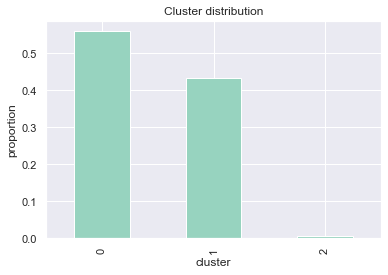

In [30]:
# Compare the proportion of data in each cluster
unique_elements, counts_elements = np.unique(cluster_pred, return_counts=True)
cluster_prop = pd.DataFrame(counts_elements, columns = ['count'], index =unique_elements) 
cluster_prop['ratio'] = cluster_prop['count']/cluster_prop['count'].sum()
cluster_prop.drop(['count'] , axis=1, inplace=True)

ax = cluster_prop.plot.bar(legend=False)
ax.set_title('Cluster distribution')
ax.set_xlabel("cluster")
ax.set_ylabel("proportion")
plt.show()

In [31]:
# Review scoring results & aggregate original features by clusters

dfF['cluster'] = cluster_pred
print(dfF.cluster.value_counts())

a = dfF.groupby('cluster')['trans_ct','total_price','tenure',
                             'duration','transgap','ratio_non_free','ratio_10plus','ratio_games',
                             'ratio_social','ratio_utili','ratio_entertain','ratio_photo',
                              'ratio_inapp_subscrb','ratio_inapp','ratio_iphone','ratio_max_single_app',
                             'ratio_top5games','ratio_top3social','ratio_top3utili','ratio_top3entertain',
                             'ratio_top3photo','ratio_highone95','ratio_highone84','ratio_highone60'].mean().reset_index()
a.T

0    14832
1    11506
2      150
Name: cluster, dtype: int64


C:\Users\steve\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,0,1,2
cluster,0.000000,1.000000,2.000000
trans_ct,150.951793,77.799061,1317.826667
total_price,1171.510829,0.000000,11020.877933
tenure,2303.801241,704.128368,2313.860000
duration,111.287756,110.050756,112.000000
transgap,0.741958,1.432731,0.084996
ratio_non_free,0.940611,0.000000,0.993207
ratio_10plus,0.286192,0.000000,0.314376
ratio_games,0.538412,0.348138,0.436829
ratio_social,0.043691,0.044434,0.054897
